Assignment 1 - part 1

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define data transformations
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,)), transforms.Lambda(lambda x: torch.flatten(x))])

# Load FashionMNIST dataset
trainset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

# Define function to prepare the data
def prepare_data(trainset, testset, batch_size):
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)
    return trainloader, testloader

# Prepare the data
batch_size = 128
trainloader, testloader = prepare_data(trainset, testset, batch_size)

100%|██████████| 26421880/26421880 [00:02<00:00, 11516561.68it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 213297.87it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3860058.73it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 10605244.10it/s]


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [2]:
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dims, output_dim):
        super(MLP, self).__init__()
        layers = []
        hidden_dims = [input_dim] + hidden_dims + [output_dim]
        for i in range(len(hidden_dims) - 1):
            layers.append(nn.Linear(hidden_dims[i], hidden_dims[i+1]))
            if i == len(hidden_dims) - 2:
              continue
            layers.append(nn.ReLU())
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

# Define function to initialize and return the MLP model
def initialize_model(input_dim, hidden_dims, output_dim):
    model = MLP(input_dim, hidden_dims, output_dim)
    model.to(device)
    return model

In [3]:
def mlp_train(hidden_dims, epochs, batch_size, learning_rate, cuda, plots):
    # Define constants
    input_dim = 28 * 28  # 28x28 input images
    output_dim = 10  # 10 classes for FashionMNIST
    
    # Initialize the model
    model = initialize_model(input_dim, hidden_dims, output_dim)
    
    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    # Move the model and loss function to CUDA if available
    if cuda:
        model.cuda()
        criterion.cuda()
    
    # Initialize lists to store losses
    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []
    
    # Training loop
    for epoch in range(epochs):
        # Initialize variables for computing losses
        train_loss = 0.0
        test_loss = 0.0
        
        train_correct_predicted = 0
        test_correct_predicted = 0
        # Training
        model.train()
        for images, labels in trainloader:
            images = images.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            # Forward pass
            logits = model(images)
            
            loss = criterion(logits, labels)
            
            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            
            # Update train loss 
            train_loss += loss.item()
            train_correct_predicted += (
                torch.argmax(logits, dim=1) == labels
            ).int().sum().item()
        
        # Compute average train loss
        train_loss = train_loss / len(trainloader)
        train_acc = train_correct_predicted / len(trainset)
        
        # Evaluation
        model.eval()
        with torch.no_grad():
            for images, labels in testloader:
                images = images.to(device)
                labels = labels.to(device)
                
                # Forward pass
                logits = model(images)
                loss = criterion(logits, labels)
                test_correct_predicted += (
                    torch.argmax(logits, dim=1) == labels
                ).int().sum().item()
                
                # Update test loss
                test_loss += loss.item()
        
        # Compute average test loss
        test_loss = test_loss / len(testloader)
        test_acc = test_correct_predicted / len(testset)
        
        # Append losses to lists
        train_losses.append(train_loss)
        test_losses.append(test_loss)

        train_accuracies.append(train_acc)
        test_accuracies.append(test_acc)
        
        # Print epoch results
        print(f"Epoch {epoch+1}/{epochs}: Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Train Accuracy: {train_acc:.4f}, Test Accuracy: {test_acc:.4f}")
    
    # Plot losses
    if plots:
        plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
        plt.plot(range(1, epochs+1), test_losses, label='Test Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.title('Train and Test Losses')
        plt.show()
        
        plt.plot(range(1, epochs+1), train_accuracies, label='Train accuracy')
        plt.plot(range(1, epochs+1), test_accuracies, label='Test accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.title('Train and Test Accuracies')
        plt.show()
    
    return model, (train_losses, test_losses)

In [4]:
def mlp_apply(model, test_indexes):
    # Set model to evaluation mode
    model.eval()

    # Get the selected test images and labels
    images = []
    labels_true = []
    for index in test_indexes:
        image, label = testset[index]
        images.append(image)
        labels_true.append(label)
    
    # Convert images and labels to tensors
    images = torch.stack(images).to(device)
    labels_true = torch.tensor(labels_true).to(device)
    
    # Perform inference
    with torch.no_grad():
        # Forward pass
        logits = model(images)
        predicted_labels = torch.argmax(logits, dim=1)
    
    # Plot the images with true and predicted labels
    fig, axs = plt.subplots(2, 5, figsize=(12, 6))
    fig.suptitle('MLP Classification Results')
    for i, ax in enumerate(axs.flat):
        ax.imshow(images[i].cpu().numpy().reshape((28, 28)), cmap='gray')
        ax.axis('off')
        ax.set_title(f"True: {labels_true[i].item()}\nPred: {predicted_labels[i].item()}")
    plt.show()

Epoch 1/10: Train Loss: 0.6400, Test Loss: 0.4780, Train Accuracy: 0.7661, Test Accuracy: 0.8231
Epoch 2/10: Train Loss: 0.4114, Test Loss: 0.4151, Train Accuracy: 0.8510, Test Accuracy: 0.8483
Epoch 3/10: Train Loss: 0.3692, Test Loss: 0.4044, Train Accuracy: 0.8644, Test Accuracy: 0.8562
Epoch 4/10: Train Loss: 0.3427, Test Loss: 0.3743, Train Accuracy: 0.8746, Test Accuracy: 0.8629
Epoch 5/10: Train Loss: 0.3226, Test Loss: 0.3643, Train Accuracy: 0.8823, Test Accuracy: 0.8646
Epoch 6/10: Train Loss: 0.3071, Test Loss: 0.3613, Train Accuracy: 0.8875, Test Accuracy: 0.8715
Epoch 7/10: Train Loss: 0.2932, Test Loss: 0.3469, Train Accuracy: 0.8911, Test Accuracy: 0.8758
Epoch 8/10: Train Loss: 0.2786, Test Loss: 0.3510, Train Accuracy: 0.8983, Test Accuracy: 0.8768
Epoch 9/10: Train Loss: 0.2722, Test Loss: 0.3496, Train Accuracy: 0.9004, Test Accuracy: 0.8770
Epoch 10/10: Train Loss: 0.2597, Test Loss: 0.3419, Train Accuracy: 0.9032, Test Accuracy: 0.8820


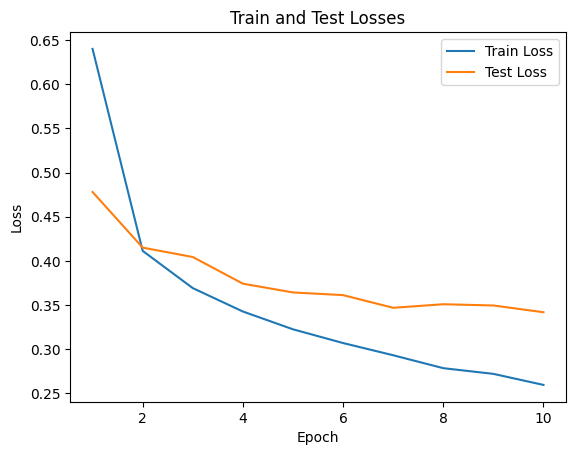

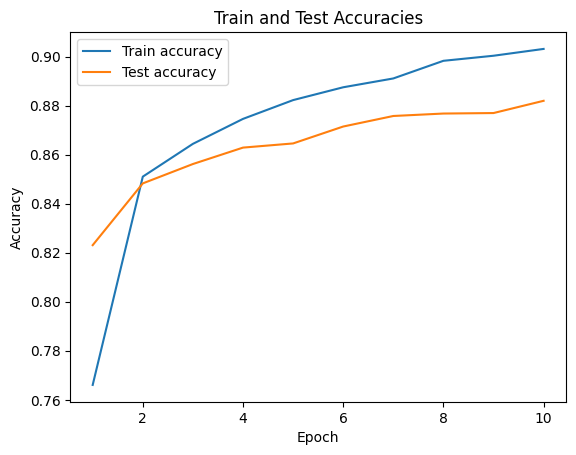

In [5]:
# The parameters are used for test execution
hidden_dims = [128, 64, 64, 32]
epochs = 10
batch_size = 128
learning_rate = 0.001
cuda = False
plots = True



# Train and evaluate MLP model
mlp_model, losses = mlp_train(hidden_dims, epochs, batch_size, learning_rate, cuda, plots)

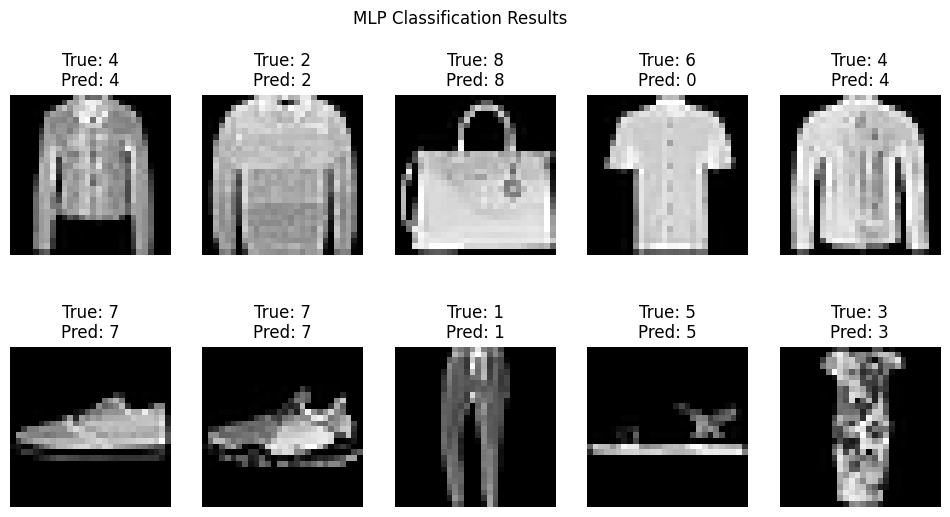

In [6]:
# User parameters
test_indexes = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

# Apply the trained model
mlp_apply(mlp_model, test_indexes)


Part - 2 CNN

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Import libraries and modules

# Step 2: Prepare the data
def prepare_data(batch_size):
    transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5,), (0.5,))])

    trainset = torchvision.datasets.FashionMNIST(
        root='./data', train=True, download=True, transform=transform)
    trainloader = torch.utils.data.DataLoader(
        trainset, batch_size=batch_size, shuffle=True, num_workers=2)

    testset = torchvision.datasets.FashionMNIST(
        root='./data', train=False, download=True, transform=transform)
    testloader = torch.utils.data.DataLoader(
        testset, batch_size=batch_size, shuffle=False, num_workers=2)

    classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot')

    return trainloader, testloader, classes

# Step 3: Define the CNN model architecture
class CNN(nn.Module):
    def __init__(self, out_channels, ff_hidden_dim):
        super(CNN, self).__init__()

        self.conv_layers = []
        
        for i in range(len(out_channels) - 1):
            self.conv_layers.append(
                nn.Sequential(
                    nn.Conv2d(
                        in_channels = 1 if i == 0 else out_channels[i-1],
                        out_channels = out_channels[i],
                        kernel_size = 3
                    ),
                    nn.ReLU(),
                    nn.MaxPool2d(2, 2)
                )
            )
      
        
        # Calculate the size of the linear layer input
        linear_input_size = self._calculate_linear_input_size()

        self.fc_layers = nn.Sequential(
            nn.Linear(linear_input_size, ff_hidden_dim),
            nn.ReLU(),
            nn.Linear(ff_hidden_dim, 10)
        )

    def forward(self, x):
        for c_layer in self.conv_layers:
            x = c_layer(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x

    def _calculate_linear_input_size(self):
        # Dummy forward pass to get the output shape of the last convolutional layer
        with torch.no_grad():
            x = torch.zeros(1, 1, 28, 28)  # Assuming input size of 28x28
            for c_layer in self.conv_layers:
                x = c_layer(x)
        
        # Calculate the size of the linear layer input
        linear_input_size = x.view(x.size(0), -1).size(1)
        return linear_input_size

# Step 4: Define the training and evaluation functions
def train(model, trainloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        correct += (torch.argmax(outputs, dim=1) == labels).int().sum().item()
        running_loss += loss.item()
    return running_loss / len(trainloader), correct / len(trainloader.dataset)

def evaluate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            correct += (torch.argmax(outputs, dim=1) == labels).int().sum().item()
    return running_loss / len(dataloader), correct / len(dataloader.dataset)

# Step 5: Train the model
def cnn_train(out_channels,epochs, batch_size, learning_rate, cuda, plots, ff_hidden_dim):
    # Prepare the data
    trainloader, testloader, classes = prepare_data(batch_size)
    # Initialize the model
    model = CNN(out_channels, ff_hidden_dim)

    # Move the model to CUDA if available
    device = torch.device("cuda" if cuda and torch.cuda.is_available() else "cpu")
    model.to(device)

    # Define the loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Lists to store the train and test losses
    train_losses = []
    test_losses = []

    train_accuracies = []
    test_accuracies = []

    # Training loop
    for epoch in range(epochs):
        train_loss, train_accuracy = train(model, trainloader, criterion, optimizer, device)
        test_loss, test_accuracy = evaluate(model, testloader, criterion, device)
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        train_accuracies.append(train_accuracy)
        test_accuracies.append(test_accuracy)

        # Print the progress
        print(f"Epoch: {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}")

    # Plot the train and test losses if enabled
    if plots:
        plt.figure(figsize=(10, 5))
        plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
        plt.plot(range(1, epochs+1), test_losses, label='Test Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Train and Test Losses')
        plt.legend()
        plt.show()

        plt.plot(range(1, epochs+1), train_accuracies, label='Train accuracy')
        plt.plot(range(1, epochs+1), test_accuracies, label='Test accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.title('Train and Test Accuracies')
        plt.show()

    return model, (train_losses, test_losses)

#Step 6: Evaluate the model
def cnn_apply(model, test_indexes):
    _, testloader, classes = prepare_data(1)
    # Get the data and labels for the test indexes
    data = []
    labels = []
    for index in test_indexes:
        image, label = testloader.dataset[index]
        data.append(image)
        labels.append(label)

    # Classify the examples and display the results
    model.eval()
    with torch.no_grad():
        data = torch.stack(data)
        data = data.to(device)
        outputs = model(data)
        predicted = outputs.argmax(dim=1)

        fig, axs = plt.subplots(2, 5, figsize=(12, 6))
        fig.suptitle('CNN Classification Results')
        for i, ax in enumerate(axs.flat):
            ax.imshow(data[i].cpu().numpy().reshape((28, 28)), cmap='gray')
            ax.axis('off')
            ax.set_title(f"True: {classes[labels[i]]}\nPred: {classes[predicted[i]]}")
        plt.show()


Epoch: 1/11, Train Loss: 0.6545, Test Loss: 0.4641, Train Accuracy: 0.7848, Test Accuracy: 0.8286
Epoch: 2/11, Train Loss: 0.4101, Test Loss: 0.4155, Train Accuracy: 0.8533, Test Accuracy: 0.8498
Epoch: 3/11, Train Loss: 0.3718, Test Loss: 0.3863, Train Accuracy: 0.8675, Test Accuracy: 0.8608
Epoch: 4/11, Train Loss: 0.3506, Test Loss: 0.3793, Train Accuracy: 0.8743, Test Accuracy: 0.8629
Epoch: 5/11, Train Loss: 0.3351, Test Loss: 0.3601, Train Accuracy: 0.8796, Test Accuracy: 0.8699
Epoch: 6/11, Train Loss: 0.3227, Test Loss: 0.3483, Train Accuracy: 0.8833, Test Accuracy: 0.8741
Epoch: 7/11, Train Loss: 0.3112, Test Loss: 0.3785, Train Accuracy: 0.8874, Test Accuracy: 0.8611
Epoch: 8/11, Train Loss: 0.3022, Test Loss: 0.3439, Train Accuracy: 0.8909, Test Accuracy: 0.8773
Epoch: 9/11, Train Loss: 0.2953, Test Loss: 0.3396, Train Accuracy: 0.8915, Test Accuracy: 0.8773
Epoch: 10/11, Train Loss: 0.2870, Test Loss: 0.3585, Train Accuracy: 0.8954, Test Accuracy: 0.8705
Epoch: 11/11, Train

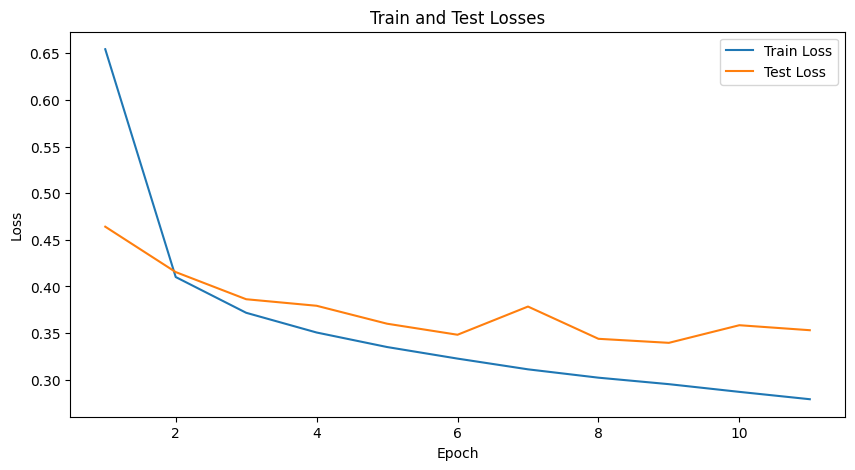

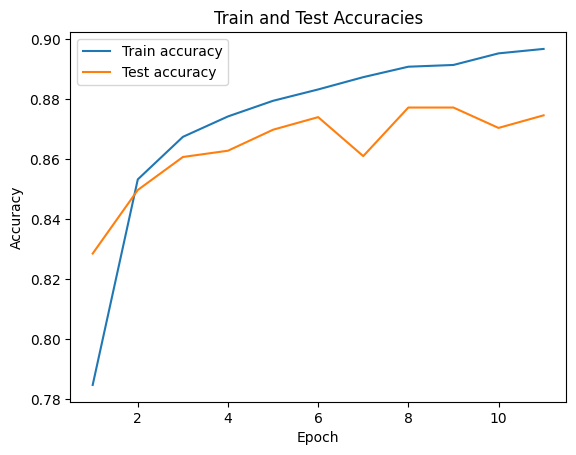

CNN(
  (fc_layers): Sequential(
    (0): Linear(in_features=845, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=10, bias=True)
  )
)


In [8]:
#Step 7: Train and evaluate the CNN model
out_channels = [5, 10]
ff_hidden_dim = 128
epochs = 11
batch_size = 128
learning_rate = 0.001
cuda = False

plots = True

cnn_model, losses = cnn_train(out_channels, epochs, batch_size, learning_rate, cuda, plots, ff_hidden_dim)
print(cnn_model)

#Step 8: Apply the trained model to classify examples


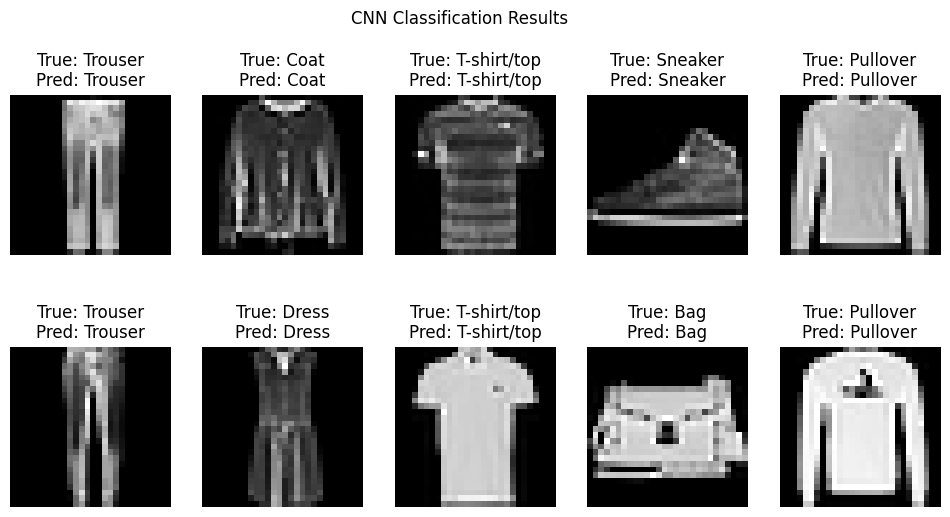

In [9]:
test_indexes = [15, 25, 35, 45, 55, 65, 75, 85, 95, 115]

cnn_apply(cnn_model, test_indexes)